# DERIVING LAPLACE TRANSFORMS

This notebook demonstrates how Laplace transforms and transfer functions can be derived directly from a chemical model.

What we present is *not* a general technique. It only works if the underlying network can be represented by a system of linear differential equations. In practice this means that: (a) all reactions have a single reactant and (b) the kinetics are masss action.

We use the following notation:
* $s$: Laplace transform variable
* $G(s)$: Transfer function
* $S_n$: $n$-th chemical species
* $S_n (t)$ time course value of $S_n$ at time $t$. If the context permits (e.g., a rate law), $S_n (t)$ is denoted by just $S_n$.
* $\dot{S}_n (t)$: First derivative of $S_n(t)$
* $S_n(s)$: Laplace Transform of the concentration of $S_n$

Reactions are described by arrows. For example, $S_1$ is converted to $S_2$ at a rate $k_1 S_1$  is denoted by $S_1 \xrightarrow{k_1 S_1} S_2$.

# Preliminaries

In [17]:
!pip install -q control
!pip install -q tellurium
import numpy as np
import control
import matplotlib.pyplot as plt
import sympy
import tellurium as te

# Helpers

In [ ]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax

    def __repr__(self):
        return ""

In [ ]:
def plotTF(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTF(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


# Model 1: 1 Stage Sequential Reaction Network

Consider the one step sequential pathway with mass action kinetics
$S_1 \xrightarrow{k_1 S_1} S_2$, $S_2 \xrightarrow{k_2 S_2} \emptyset$

We want to control $S_2$ by manipulating $S_1$.
We will manipulate $S_1$ externally. For example, in a chemostat we might add more $S_1$ as it concentration calls.

We want the transfer function $G(s) = \frac{S_2(s)}{S_1(s)}$.

## 1. System equations

$S_1  \xrightarrow{k_1 S_1 } S_2$, $S_2 \xrightarrow{k_2 S_2} \emptyset$

We do not analyze $\dot{S}_1$ since it is treated as a boundary species (a forced input).
* $\dot{S}_2 = k_1 S_1 - k_2 S_2$

## 2. LT of system equations

Going from the state equations to Laplace Transforms is very mechanical. Replace $\dot{x}$ with $s X(s)$, and replace $x$ with $X(s)$.

\begin{eqnarray}
s S_2 (s) & = & k_1 S_1 (s) - k_2 S_2(s) \\
\end{eqnarray}

## 3. Solve for transfer function

$G(s) = \frac{S_2 (s)}{S_1 (s)} = \frac{k_1}{s + k_2}$

**Questions**
* What are the poles of $G(s)$?
* What is the DC gain of $G(s)$?

## 4. Predict step response from TF

### 4a. Construct transfer function

The function ``control.TransferFunction`` provides a way to construct transfer functions and calculate with them.

A transfer function represented by a numerator polynomial in $s$ and a denominator polynomial in $s$.
A polynomial in $s$ is a list of floats.
The last element of the list is the coefficient for $s^0$;
element last - 1 is the coefficient for $s^1$; and so on.

For example, [1, 2, 3] represents the polynomial $s^2 + 2 s + 3$.

In [ ]:
# Describing a polynomial in s
# The list [1, 2, 3] species a polynomial that is s**2 + 2*s + 3

In [ ]:
# Write the transfer function for 1/(s**2 + 5)
control.TransferFunction([1], [1, 0, 5])

TransferFunction(array([1]), array([1, 0, 5]))

In [20]:
# Construct the transfer function for G(s) at k1=1, k2=2
k1 = 1
k2 = 2
G_tf = control.TransferFunction([k1], [1, k2])
G_tf

TransferFunction(array([1]), array([1, 2]))

In [21]:
# The controls package calculates poles of transfer functions
G_tf.poles()

array([-2.+0.j])

In [22]:
# The controls package also calculates DC Gain
G_tf.dcgain()

0.5

### 4b. Predict step response

Text(0.5, 0, 'time')

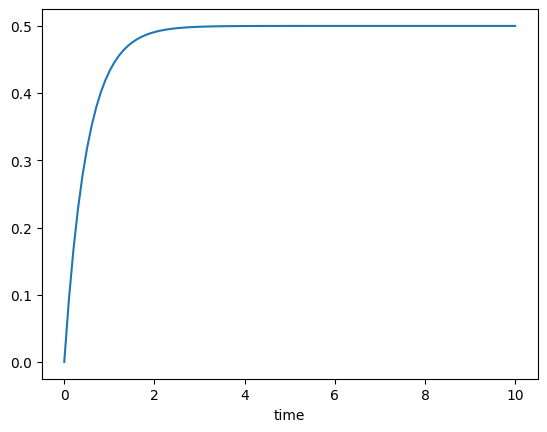

In [23]:
# Use control.forced_response
times = np.linspace(0, 10, 100)
_, yt = control.step_response(G_tf, T=times)
plt.plot(times, yt)
plt.xlabel("time")

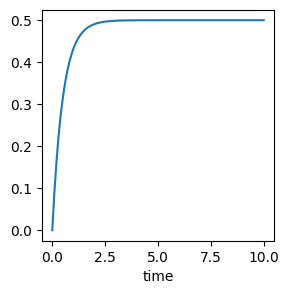

In [24]:
# We can wrap the foregoing into a function
plotTF(G_tf, figsize=(3,3))

## 5. Simulate the Antimony model

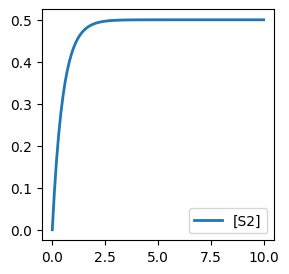

In [26]:
SEQUENTIAL_MODEL = """
$S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 1
S2 = 0
k1 = 1
k2 = 2
"""
rr = te.loada(SEQUENTIAL_MODEL)
rr.simulate(0, 10, 100)
rr.plot(figsize=(3,3))

### More accurate and scalable way to compare models

Want to know if the simulated (actual) values and predicted (from transfer function) are the same at each time step. This means that one they are plotted, each point lines on the line of unit slope.

Text(0, 0.5, 'predicted')

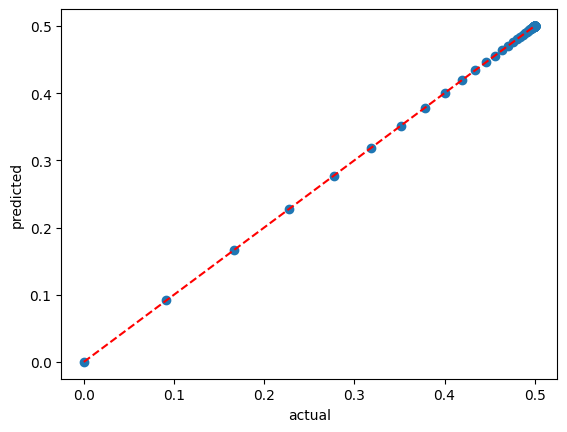

In [30]:
rr = te.loada(SEQUENTIAL_MODEL)
data = rr.simulate(0, 10, 100)
times = data["time"]
_, yt = control.step_response(G_tf, T=times)
plt.scatter(data["[S2]"], yt)
plt.plot([0, 0.5], [0, 0.5], color="red", linestyle="--")
plt.xlabel("actual")
plt.ylabel("predicted")

## 6: Analyze

All points line on the line of unit slope.

# Model 2: A more elaborate network

Consider the following model:
\begin{eqnarray}
S_1 & \xrightarrow{k_1 S_1} & S_2 \\
S_2 & \xrightarrow{k_2 S_2} & 2 S_2 + S_3 \\
S_3 & \xrightarrow{k_3 S_3} & \emptyset
\end{eqnarray}

Find the transfer function $G(s) = \frac{S_3 (s)}{S_1 (s)}$.

## 1. System equations

\begin{eqnarray}
\dot{x}_1 & = &  -k_1 x_1 \\
\dot{x}_2 & = & k_1 x_1 - k_2 x_2\\
\dot{x}_3 & = & k_2 x_2 - k_3 x_3 \\
\end{eqnarray}

## 2. LT of system equations

\begin{eqnarray}
s X_1 (s) & = &  -k_1 X_1 (s) \\
s X_2 (s) & = & k_1 X_1 (s) - k_2 X_2 (s) \\
s X_3 (s) & = & k_2 X_2 (s) - k_3 X_3 (s) \\
\end{eqnarray}

## 3. Solve for the LT

Solve backwards from $X_3 (s)$

\begin{eqnarray}
X_3(s) & = &  \frac{k_2 X_2(s)}{s + k_3} \\
X_2(s) & = &  \frac{k_1 X_1(s)}{s + k_2} \\
\end{eqnarray}

Substituting
\begin{eqnarray}
X_3(s) & = &  \frac{k_2 \frac{k_1 X_1(s)}{s + k_2}}{s + k_3} \\
& = & \frac{k_2 k_1 X_1(s)}{(s + k_3)(s + k_2)} \\
G(s) & = & \frac{X_3(s)}{X_1(s)} \\
& = & \frac{k_2 k_1 }{(s + k_3)(s + k_2)} \\
\end{eqnarray}

## 3a. Interpret $G(s)$

* The poles are $k_2, k_3$. Why?
* The system is always stable. Why?
* The DC Gain is $\frac{k_1}{k_3}$ Why?

## 4. Predict step response from TF

In [ ]:
# Construct the transfer function for G(s) at k1=1
k1, k2, k3 = 1, 2, 3
G_tf = control.TransferFunction([k2*k1], [1, k2+k3, k2*k3])
G_tf

TransferFunction(array([2]), array([1, 5, 6]))

In [ ]:
G_tf.dcgain(), G_tf.poles()

(np.float64(0.3333333333333333), array([-3.+0.j, -2.+0.j]))

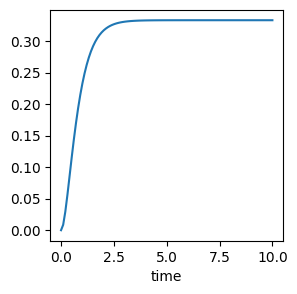

In [ ]:
plotTF(G_tf, figsize=(3,3))

## 5. Simulate the Antimony Model

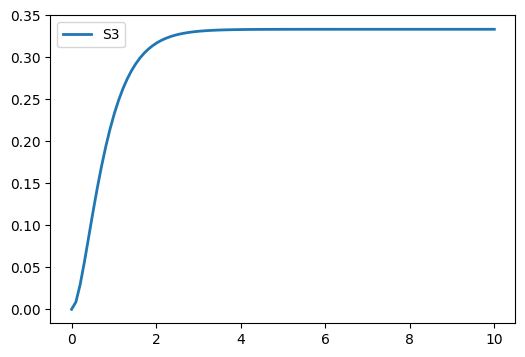

In [ ]:
# Model for a unit step response
model = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

$S1 = 1
S2 = 0
S3 = 0
k1 = 1
k2 = 2
k3 = 3
"""
rr = te.loada(model)
rr.simulate(0, 10, 100, selections=['time', 'S3'])
rr.plot()

## 6. Analyze

The actual results match the predicted results, including DC Gain.

# Exercise: Fork-Join

Consider the following network. Find its transfer function and compare with an Antimony simulation.

\begin{eqnarray}
S_1 & \xrightarrow{k_{12} x_1} & S_2 \\
S_1 & \xrightarrow{k_{13} x_1} & S_3 \\
S_2 & \xrightarrow{k_2 x_2} & S_4 \\
S_3 & \xrightarrow{k_3 x_3} & S_4 \\
S_4 & \xrightarrow{k_4 x_4} & \emptyset \\
\end{eqnarray}
Find $G(s) = \frac{X_4(s)}{X_1(s)}$

## System equations

## LT of system equations

## Solve for transfer function & simulate a step response

## Do an Antimony stimulation of a step response

## Evaluate the result